#YOLO 과제

##0. 필요 라이브러리 다운로드

In [ ]:
!pip install ultralytics

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: http://repo.ai.gato/registry/repository/pypi-proxy/simple


##1. 라이브러리 임포트

In [ ]:
import os
import cv2
import yaml
import torch
from ultralytics import YOLO
import matplotlib.pyplot as plt
from PIL import Image

##2. 어노테이션 변환 함수

- 얼굴이 없는 이미지면 스킵

- face_count 만큼의 줄에서 (x1, y1, w, h) 얻어서 YOLO 형식으로 변환

- 라벨 파일 이름과 이미지 파일 이름이 동일해야 하므로, data_{번호}로 동일하게 생성

In [ ]:
def convert_annotations(images_directory, annotations_path, output_directory):

    with open(annotations_path, "r") as anno_file:
        annotation_lines = anno_file.readlines()

    saved_image_count = 0

    for annotation_line in annotation_lines:
        if ".jpg" in annotation_line:
            image_rel_path = annotation_line.strip()
            full_image_path = os.path.join(images_directory, image_rel_path)

            image_data = cv2.imread(full_image_path)
            if image_data is None:
                continue

            face_count_line = annotation_lines[annotation_lines.index(annotation_line) + 1].strip()
            try:
                face_count = int(face_count_line)
            except ValueError:
                continue

            bbox_start_idx = annotation_lines.index(annotation_line) + 2
            bbox_end_idx = bbox_start_idx + face_count

            yolo_label_data = []

            for bbox_idx in range(bbox_start_idx, bbox_end_idx):
                bbox_line = annotation_lines[bbox_idx].strip()
                bbox_vals = bbox_line.split(" ")

                x1 = int(bbox_vals[0])
                y1 = int(bbox_vals[1])
                w = int(bbox_vals[2])
                h = int(bbox_vals[3])

                img_h, img_w = image_data.shape[:2]

                x_center_rel = (x1 + w / 2) / img_w
                y_center_rel = (y1 + h / 2) / img_h
                w_rel = w / img_w
                h_rel = h / img_h

                yolo_label_str = f"0 {x_center_rel} {y_center_rel} {w_rel} {h_rel}"
                yolo_label_data.append(yolo_label_str)

            new_name = f"data_{saved_image_count}"

            output_image_path = os.path.join(output_directory, new_name + ".jpg")
            cv2.imwrite(output_image_path, image_data)

            output_label_path = os.path.join(output_directory, new_name + ".txt")
            with open(output_label_path, "w") as label_file:
                for label_line in yolo_label_data:
                    label_file.write(label_line + "\n")

            saved_image_count += 1

##3. 경로 설정 및 변환 실행

In [ ]:
# 학습 관련 경로
images_directory_train = "./datasets/WIDER_train/images/"
annotations_path_train = "./datasets/wider_face_split/wider_face_train_bbx_gt.txt"
output_directory_train = "./datasets/train/"

# 검증 관련 경로
images_directory_val = "./datasets/WIDER_val/images/"
annotations_path_val = "./datasets/wider_face_split/wider_face_val_bbx_gt.txt"
output_directory_val = "./datasets/val/"

In [ ]:
os.makedirs(output_directory_train, exist_ok=True)
convert_annotations(images_directory_train, annotations_path_train, output_directory_train)

In [ ]:
os.makedirs(output_directory_val, exist_ok=True)
convert_annotations(images_directory_val, annotations_path_val, output_directory_val)

##4. data.yaml 파일 생성

In [ ]:
data = {
    "train": "/home/20203100/users/20203100/다운로드/datasets/train",
    "val": "/home/20203100/users/20203100/다운로드/datasets/val",
    "nc": 1,
    "names": ["face"]
}

with open("data.yaml", "w") as f:
    yaml.dump(data, f, default_flow_style=False)

##5. 모델 학습

- pre-trained된 yolo11 nano모델 사용

In [ ]:
model = YOLO("yolo11n.pt")

In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

cuda:0


In [ ]:
train_results = model.train(
    data="./data.yaml",
    epochs=20,
    imgsz=640,
    device=device,
    workers=4,
    project='runs/train',
    exist_ok=True,
    save=True
)

New https://pypi.org/project/ultralytics/8.3.85 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.78 🚀 Python-3.10.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX A5000, 24123MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=./data.yaml, epochs=20, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cuda:0, workers=4, project=runs/train, name=train, exist_ok=True, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=

train: Scanning /home/20203100/users/20203100/다운로드/datasets/train... 12880 images, 4 backgrounds, 1 corrupt: 100%|██████████| 12880/12880 [10:32<00:00, 20.35it/s]

train: WARNING ⚠️ /home/20203100/users/20203100/다운로드/datasets/train/data_10969.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0254]
train: WARNING ⚠️ /home/20203100/users/20203100/다운로드/datasets/train/data_12381.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /home/20203100/users/20203100/다운로드/datasets/train/data_3232.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /home/20203100/users/20203100/다운로드/datasets/train/data_7207.jpg: 1 duplicate labels removed


train: New cache created: /home/20203100/users/20203100/다운로드/datasets/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /home/20203100/users/20203100/다운로드/datasets/val... 3226 images, 0 backgrounds, 1 corrupt: 100%|██████████| 3226/3226 [00:35<00:00, 91.60it/s] 

val: WARNING ⚠️ /home/20203100/users/20203100/다운로드/datasets/val/data_1060.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /home/20203100/users/20203100/다운로드/datasets/val/data_1885.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      1.002]


val: New cache created: /home/20203100/users/20203100/다운로드/datasets/val.cache
Plotting labels to runs/train/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)


2025/03/09 00:56:24 INFO mlflow.bedrock: Enabled auto-tracing for Bedrock. Note that MLflow can only trace boto3 service clients that are created after this call. If you have already created one, please recreate the client by calling `boto3.client`.
2025/03/09 00:56:24 INFO mlflow.tracking.fluent: Autologging successfully enabled for boto3.
2025/03/09 00:56:26 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.


MLflow: logging run_id(4632c9137f874950a9d05da5dcf71a21) to http://127.0.0.1:5000
MLflow: disable with 'yolo settings mlflow=False'
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 1 dataloader workers
Logging results to runs/train/train
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      16.9G      1.868      1.503      1.129        381        640: 100%|██████████| 805/805 [37:35<00:00,  2.80s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 101/101 [09:53<00:00,  5.87s/it]


                   all       3225      39675      0.686        0.4      0.456      0.224

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      14.4G      1.724      1.083      1.071        795        640: 100%|██████████| 805/805 [48:03<00:00,  3.58s/it]  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 101/101 [10:21<00:00,  6.15s/it]


                   all       3225      39675      0.742      0.446      0.507      0.254

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      17.4G        1.7      1.039      1.064        382        640: 100%|██████████| 805/805 [42:32<00:00,  3.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 101/101 [09:24<00:00,  5.59s/it]


                   all       3225      39675      0.754      0.441      0.516      0.268

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      15.8G      1.645     0.9782       1.05        488        640: 100%|██████████| 805/805 [40:16<00:00,  3.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 101/101 [09:33<00:00,  5.68s/it]


                   all       3225      39675      0.763      0.474      0.536      0.267

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      17.6G      1.617     0.9446      1.039        287        640: 100%|██████████| 805/805 [40:09<00:00,  2.99s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 101/101 [08:46<00:00,  5.21s/it]


                   all       3225      39675      0.777      0.494      0.559      0.292

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      11.9G      1.589     0.9098      1.034        217        640: 100%|██████████| 805/805 [39:53<00:00,  2.97s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 101/101 [08:40<00:00,  5.15s/it]


                   all       3225      39675       0.79      0.495      0.564      0.299

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      17.9G      1.571     0.8866      1.022        239        640: 100%|██████████| 805/805 [38:53<00:00,  2.90s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 101/101 [08:42<00:00,  5.17s/it]


                   all       3225      39675      0.795      0.501      0.569      0.295

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      15.9G      1.554     0.8688      1.017        196        640: 100%|██████████| 805/805 [38:13<00:00,  2.85s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 101/101 [10:47<00:00,  6.41s/it]


                   all       3225      39675       0.81      0.516      0.593       0.31

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      10.5G      1.538      0.854      1.014        102        640: 100%|██████████| 805/805 [39:45<00:00,  2.96s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 101/101 [09:51<00:00,  5.85s/it]


                   all       3225      39675      0.801      0.516       0.59      0.311

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      17.4G      1.525     0.8354      1.012        143        640: 100%|██████████| 805/805 [40:04<00:00,  2.99s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 101/101 [08:39<00:00,  5.15s/it]


                   all       3225      39675      0.803      0.526      0.595      0.315
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      14.2G      1.493     0.8064      1.013        154        640: 100%|██████████| 805/805 [36:35<00:00,  2.73s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 101/101 [08:51<00:00,  5.26s/it]


                   all       3225      39675      0.813      0.519      0.596      0.318

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      14.7G      1.483     0.7925      1.011        317        640: 100%|██████████| 805/805 [36:39<00:00,  2.73s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 101/101 [03:33<00:00,  2.12s/it]


                   all       3225      39675      0.811      0.523        0.6       0.32

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      20.6G      1.472     0.7757      1.005         67        640: 100%|██████████| 805/805 [10:13<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 101/101 [01:59<00:00,  1.18s/it]


                   all       3225      39675      0.813       0.53      0.607      0.325

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      19.4G      1.456     0.7624      1.001        117        640: 100%|██████████| 805/805 [08:45<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 101/101 [00:50<00:00,  2.02it/s]


                   all       3225      39675      0.817      0.533      0.613       0.33

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      16.7G       1.45     0.7495     0.9992        207        640: 100%|██████████| 805/805 [07:57<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 101/101 [00:53<00:00,  1.87it/s]


                   all       3225      39675      0.817      0.535       0.61      0.329

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20        16G       1.44     0.7375     0.9913        171        640: 100%|██████████| 805/805 [09:01<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 101/101 [01:48<00:00,  1.07s/it]


                   all       3225      39675      0.819      0.541      0.617      0.332

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      13.9G      1.425     0.7229     0.9878        192        640: 100%|██████████| 805/805 [09:30<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 101/101 [01:48<00:00,  1.07s/it]


                   all       3225      39675       0.82      0.541      0.621      0.336

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      14.5G      1.416     0.7131     0.9871        201        640: 100%|██████████| 805/805 [09:05<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 101/101 [01:58<00:00,  1.17s/it]


                   all       3225      39675      0.822      0.547      0.626      0.339

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      12.9G      1.403     0.7013     0.9831        103        640: 100%|██████████| 805/805 [09:02<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 101/101 [01:23<00:00,  1.21it/s]


                   all       3225      39675      0.827      0.551       0.63      0.341

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      13.8G      1.392     0.6898     0.9792        222        640: 100%|██████████| 805/805 [09:02<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 101/101 [01:34<00:00,  1.06it/s]


                   all       3225      39675      0.825      0.553      0.631      0.343

20 epochs completed in 11.236 hours.
Optimizer stripped from runs/train/train/weights/last.pt, 5.4MB
Optimizer stripped from runs/train/train/weights/best.pt, 5.4MB

Validating runs/train/train/weights/best.pt...
Ultralytics 8.3.78 🚀 Python-3.10.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX A5000, 24123MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 101/101 [00:53<00:00,  1.90it/s]


                   all       3225      39675      0.826      0.553      0.631      0.343
Speed: 0.1ms preprocess, 0.6ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to runs/train/train
🏃 View run train at: http://127.0.0.1:5000/#/experiments/957504960308323900/runs/4632c9137f874950a9d05da5dcf71a21
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/957504960308323900
MLflow: results logged to http://127.0.0.1:5000
MLflow: disable with 'yolo settings mlflow=False'


##6. 결과 이미지
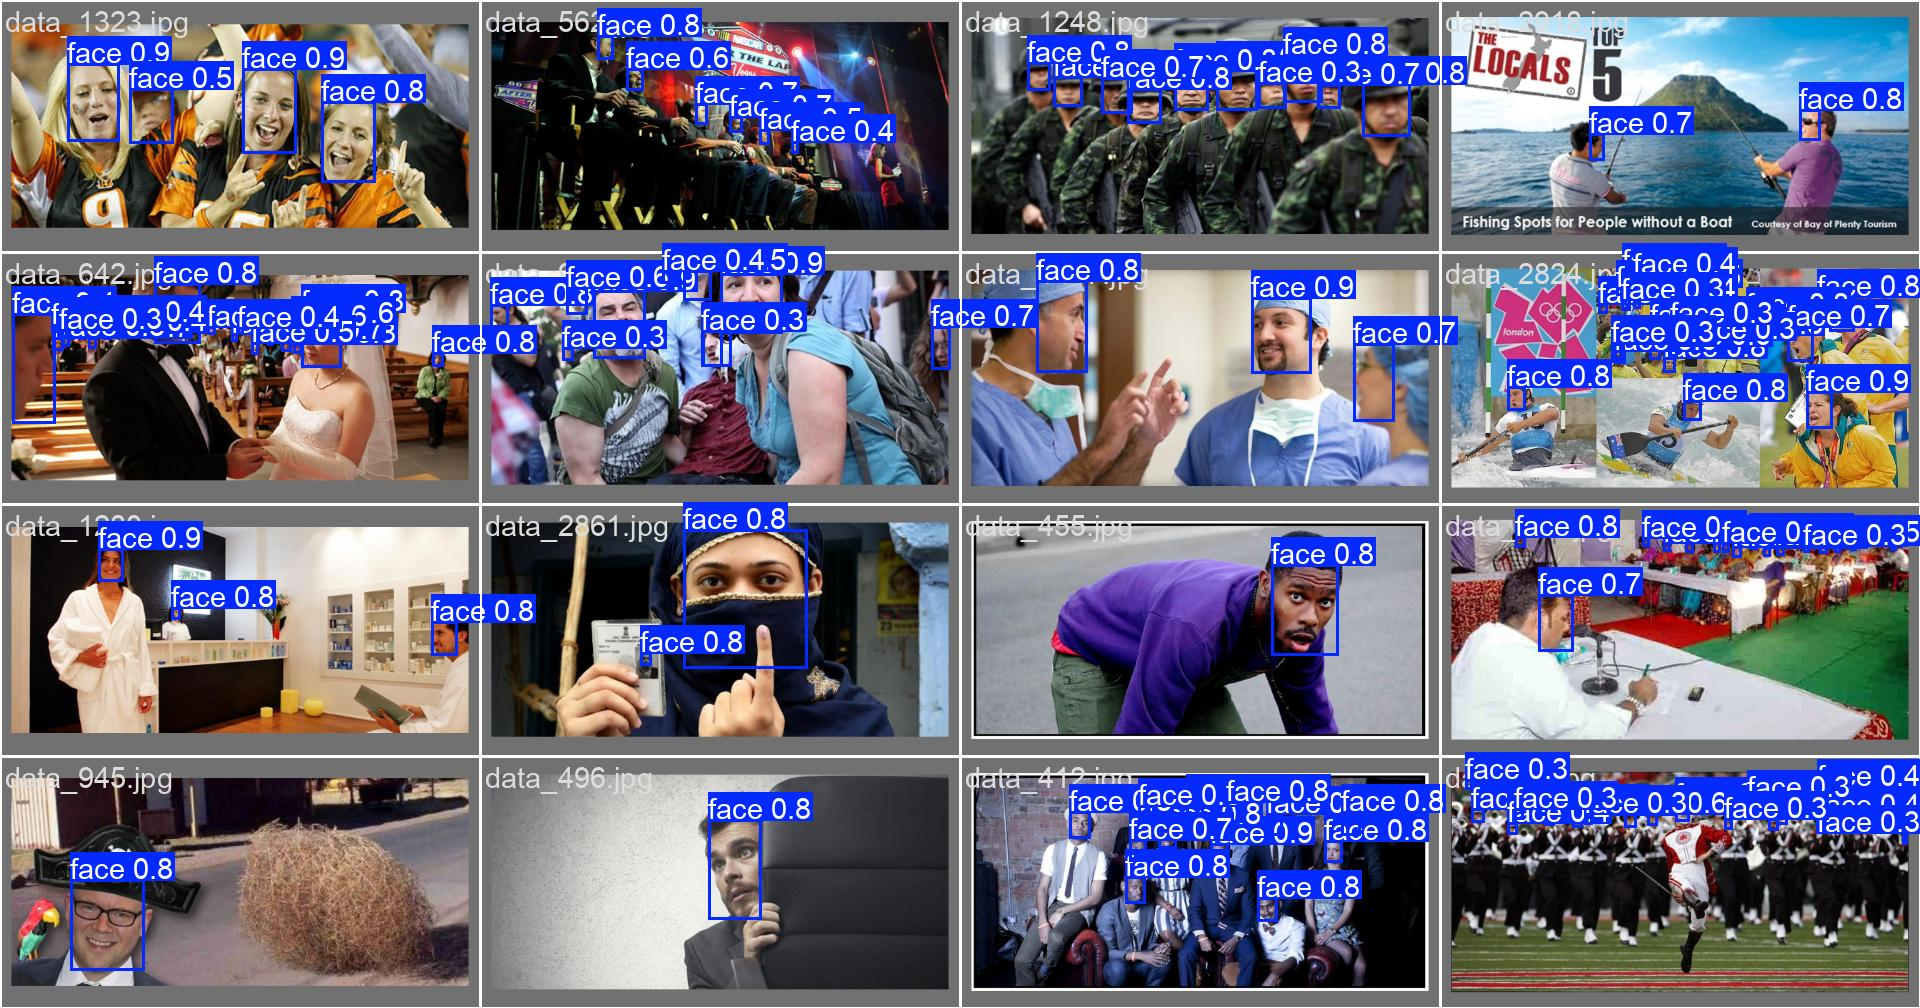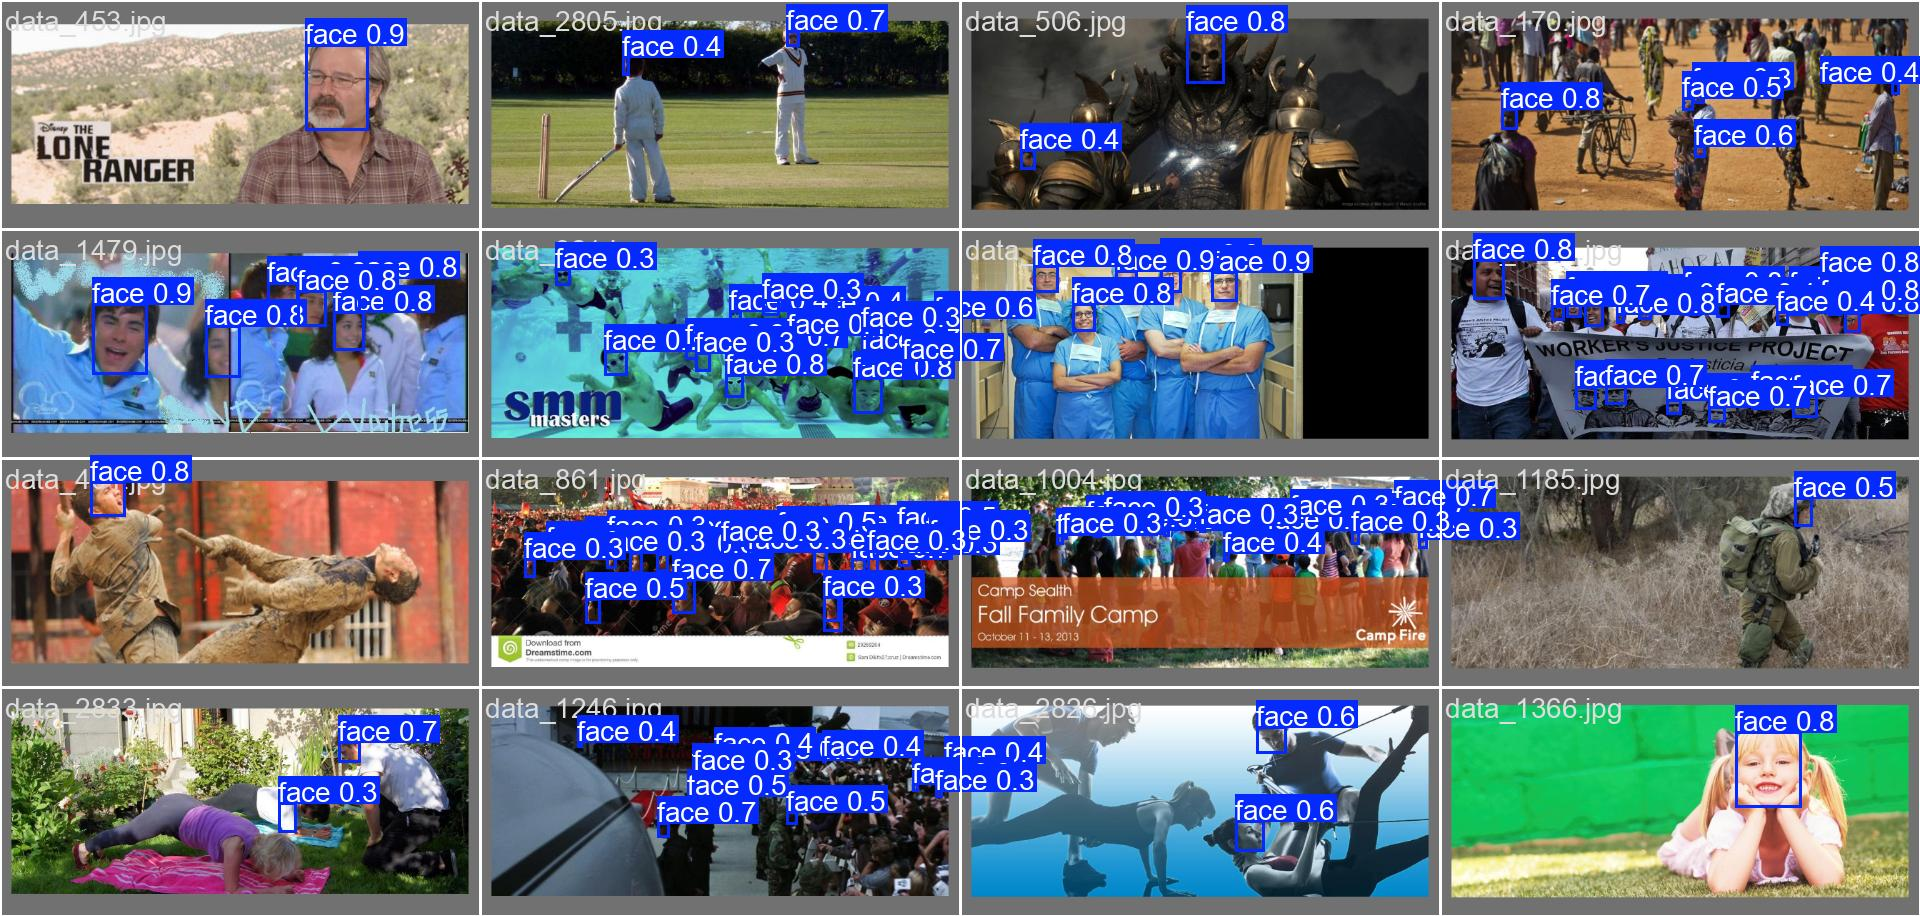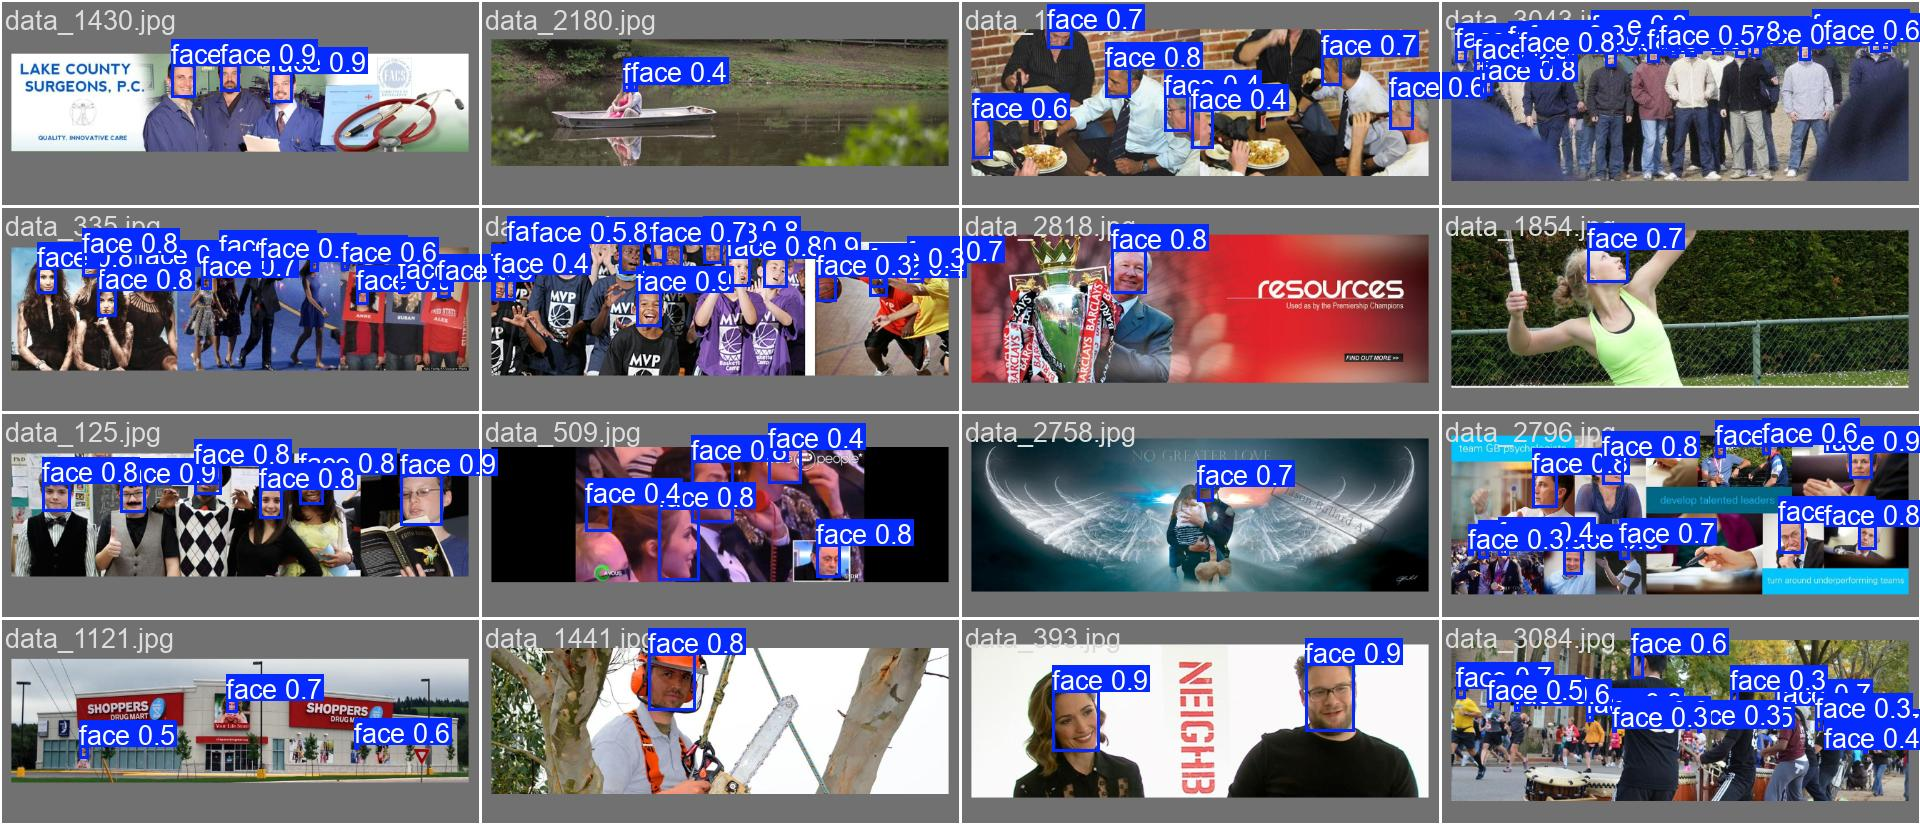

##어려웠던 점

- WiderFace 데이터셋은 라벨 값을 얻기 위해 어노테이션 변환을 이용해야 하는데 처음 해보는 과정이라 많이 해맸다.

- 특히 WiderFace의 어노테이션은 이미지별로 다양한 정보를 포함하고 있어, YOLO가 요구하는 [클래스, x_center, y_center, w, h] 형식으로 변환하는 과정에서 불필요한 정보(blur, occlusion 등)를 무시하는 처리가 어려웠다.

- 얼굴이 없는 경우에도 빈 라벨 파일을 생성하도록 하여 YOLO가 데이터셋을 잘 받아들이도록 하였다.

##분석 및 고찰

- 초기 학습 단계에서는 모델이 얼굴을 잘 검출하지 못하는 것을 극복하고자 검증할 때의 threshold를 0.001정도로 낮게 설정하여 최소한의 예측이라도 생성하도록 하였다.

- 작은 얼굴은 잘 검출해내지 못하는 것을 보이는데 이런 작은 얼굴을 검출해내는 성능 향상을 위한 추가적인 기법이 필요로 해보인다.
